In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 100
learning_rate = 0.0002
num_epoch = 1

mnist_train = dset.MNIST(root='./', train=True, transform=transforms.ToTensor(), target_transform=None, download=True) 
mnist_test = dset.MNIST(root='./', train=False, transform=transforms.ToTensor(), target_transform=None, download=True) 

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
                      nn.Conv2d(1,16,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(16),
                      nn.Conv2d(16,32,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(32),
                      nn.Conv2d(32,64,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(64),
                      nn.MaxPool2d(2,2)
    )
    self.layer2 = nn.Sequential(
                      nn.Conv2d(64,128,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(128),
                      nn.MaxPool2d(2,2),
                      nn.Conv2d(128,256,3,padding=1),
                      nn.ReLU()
    )
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1) # 뽑아낸 Feature를 1차원으로 reshape
    return out

encoder = Encoder().cuda()
print(encoder)

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(
                      nn.ConvTranspose2d(256,128,3,2,1,1),
                      nn.ReLU(),
                      nn.BatchNorm2d(128),
                      nn.ConvTranspose2d(128,64,3,1,1),
                      nn.ReLU(),
                      nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
                      nn.ConvTranspose2d(64,16,3,1,1),
                      nn.ReLU(),
                      nn.BatchNorm2d(16),
                      nn.ConvTranspose2d(16,1,3,2,1,1),
                      nn.ReLU()
    )
  def forward(self,x):
    out = x.view(batch_size,256,7,7) # 받아낸 input값을 4차원으로 reshape
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()
print(decoder)

Encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stri

In [3]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    optimizer.zero_grad()

    image = Variable(image).cuda()
    output = encoder(image)
    output = decoder(output)
    loss = loss_func(output, image)

    loss.backward()
    optimizer.step() 

    if j % 50 == 0:
       print("Epoch[{}/{}] MSE Loss: {:.5f}".format(i+1, num_epoch, loss.item()))

  val_loss = 0

  for j, [image, label] in enumerate(test_loader):
    image = Variable(image, requires_grad=False).cuda()
    output = encoder(image)
    output = decoder(output)
    val_loss += loss_func(output, image).item()
  print("Epoch[{}/{}] Validation MSE Loss: {:.5f}".format(i+1, num_epoch, val_loss/len(test_loader)))

Epoch[1/1] MSE Loss: 0.83735
Epoch[1/1] MSE Loss: 0.05559
Epoch[1/1] MSE Loss: 0.03450
Epoch[1/1] MSE Loss: 0.02349
Epoch[1/1] MSE Loss: 0.01691
Epoch[1/1] MSE Loss: 0.01318
Epoch[1/1] MSE Loss: 0.01056
Epoch[1/1] MSE Loss: 0.00879
Epoch[1/1] MSE Loss: 0.00776
Epoch[1/1] MSE Loss: 0.00645
Epoch[1/1] MSE Loss: 0.00563
Epoch[1/1] MSE Loss: 0.00523
Epoch[1/1] Validation MSE Loss: 0.00548


Original Images


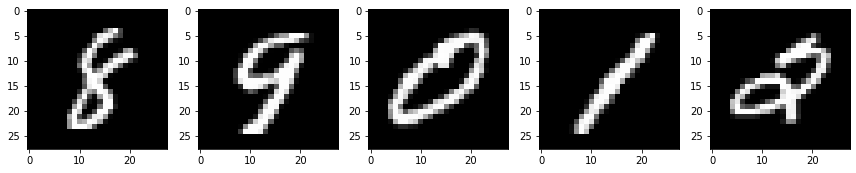


Auto Encoder Images


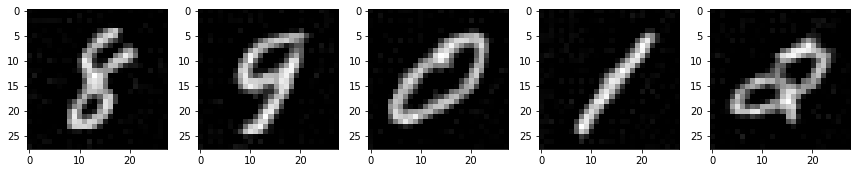

In [4]:
print(('Original Images'))
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(12, 6)
for i in range(5):
    axes[i%5].imshow(image[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

print('')

print(('Auto Encoder Images'))
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(12, 6)
for i in range(5):
    axes[i%5].imshow(output[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
# 생성 실험 1: 첫번째 샘플의 input image에 잡음을 섞어 새로운 샘플 생성
# 인코더에 넣기 전 이미지에 잡음 섞음

del encoder
del decoder

encoder = Encoder().cuda()
decoder = Decoder().cuda()

parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

for epoch in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    noise = init.normal_(torch.FloatTensor(batch_size,1,28,28), mean=0, std=0.1)
    noise = Variable(noise.cuda())
    optimizer.zero_grad()
    image = Variable(image).cuda()
    noise_image = image + noise
    output = encoder(noise_image)
    output = decoder(output)
    loss = loss_func(output, image)
    loss.backward()
    optimizer.step()
    if j % 50 == 0:
       print("Epoch[{}/{}] MSE Loss: {:.5f}".format(epoch+1, num_epoch, loss.item()))

  val_loss = 0

  for j, [image, label] in enumerate(test_loader):
    noise = init.normal_(torch.FloatTensor(batch_size,1,28,28), mean=0, std=0.1)
    noise = Variable(noise.cuda())
    optimizer.zero_grad()
    image = Variable(image, requires_grad=False).cuda()
    noise_image = image + noise
    output = encoder(noise_image)
    output = decoder(output)
    val_loss += loss_func(output, image).item()
  print("Epoch[{}/{}] Validation MSE Loss: {:.5f}".format(epoch+1, num_epoch, val_loss/len(test_loader)))

Epoch[1/1] MSE Loss: 0.67220
Epoch[1/1] MSE Loss: 0.03882
Epoch[1/1] MSE Loss: 0.02283
Epoch[1/1] MSE Loss: 0.01514
Epoch[1/1] MSE Loss: 0.01184
Epoch[1/1] MSE Loss: 0.01071
Epoch[1/1] MSE Loss: 0.00895
Epoch[1/1] MSE Loss: 0.00811
Epoch[1/1] MSE Loss: 0.00753
Epoch[1/1] MSE Loss: 0.00648
Epoch[1/1] MSE Loss: 0.00591
Epoch[1/1] MSE Loss: 0.00541
Epoch[1/1] Validation MSE Loss: 0.00582


Original Images


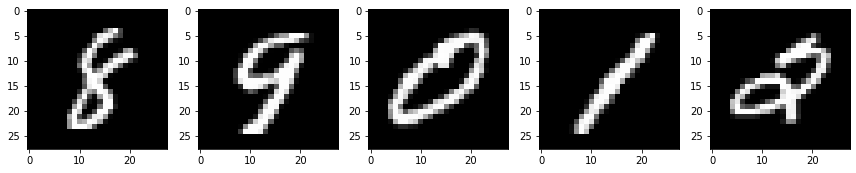


Auto Encoder Images


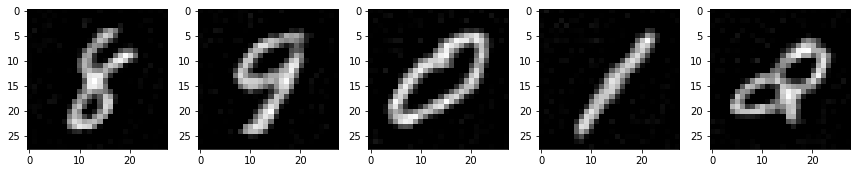

In [ ]:
print(('Original Images'))
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(12, 6)
for i in range(5):
    axes[i%5].imshow(image[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

print('')

print(('Auto Encoder Images'))
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(12, 6)
for i in range(5):
    axes[i%5].imshow(output[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

In [5]:
# 생성 실험 2: 첫번째 샘플의 Feature 공간 표현에 잡음을 섞어 새로운 샘플 생성
# 인코더에 넣은 후 나온 결과에 잡음 섞음

del encoder
del decoder

encoder = Encoder().cuda()
decoder = Decoder().cuda()

parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

for epoch in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    optimizer.zero_grad()
    image = Variable(image).cuda()
    output = encoder(image)
    noise = init.normal_(torch.FloatTensor(batch_size,12544), mean=0, std=0.1)
    noise = Variable(noise).cuda()
    noise_output = output + noise
    output = decoder(noise_output)
    loss = loss_func(output, image)
    loss.backward()
    optimizer.step()
    if j % 50 == 0:
       print("Epoch[{}/{}] MSE Loss: {:.5f}".format(epoch+1, num_epoch, loss.item()))

  val_loss = 0

  for j, [image, label] in enumerate(test_loader):
    optimizer.zero_grad()
    image = Variable(image, requires_grad=False).cuda()
    noise = init.normal_(torch.FloatTensor(batch_size,12544), mean=0, std=0.1)
    noise = Variable(noise.cuda())
    output = encoder(image)
    noise_output = output + noise
    output = decoder(noise_output)
    val_loss += loss_func(output, image).item()
  print("Epoch[{}/{}] Validation MSE Loss: {:.5f}".format(epoch+1, num_epoch, val_loss/len(test_loader)))

Epoch[1/1] MSE Loss: 1.05975
Epoch[1/1] MSE Loss: 0.05720
Epoch[1/1] MSE Loss: 0.03875
Epoch[1/1] MSE Loss: 0.02859
Epoch[1/1] MSE Loss: 0.02019
Epoch[1/1] MSE Loss: 0.01831
Epoch[1/1] MSE Loss: 0.01363
Epoch[1/1] MSE Loss: 0.01052
Epoch[1/1] MSE Loss: 0.00917
Epoch[1/1] MSE Loss: 0.00771
Epoch[1/1] MSE Loss: 0.00693
Epoch[1/1] MSE Loss: 0.00701
Epoch[1/1] Validation MSE Loss: 0.00667


Original Images


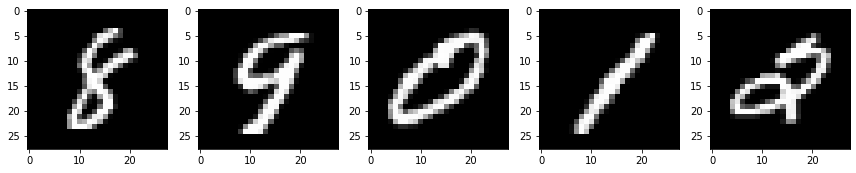


Auto Encoder Images


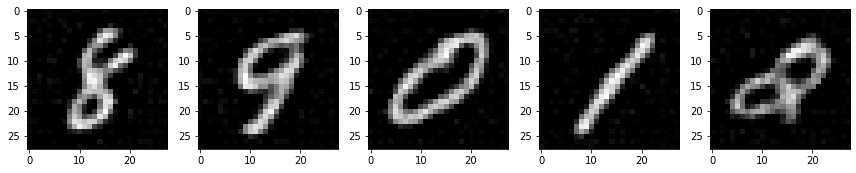

In [6]:
print(('Original Images'))
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(12, 6)
for i in range(5):
    axes[i%5].imshow(image[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

print('')

print(('Auto Encoder Images'))
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(12, 6)
for i in range(5):
    axes[i%5].imshow(output[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
# 2차원 잠복 공간 관찰

# 시각화를 위해 2차원으로 축소하는 인코더-디코더 모델 정의

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
                      nn.Conv2d(1,16,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(16),
                      nn.Conv2d(16,32,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(32),
                      nn.Conv2d(32,64,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(64),
                      nn.MaxPool2d(2,2)
    )
    self.layer2 = nn.Sequential(
                      nn.Conv2d(64,128,3,padding=1),
                      nn.ReLU(),
                      nn.BatchNorm2d(128),
                      nn.MaxPool2d(2,2),
                      nn.Conv2d(128,256,3,padding=1),
                      nn.ReLU()
    )
    # fc를 마지막에 붙여 2차원 분포값만 남김
    self.fc = nn.Linear(12544,2)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1) # 뽑아낸 Feature를 1차원으로 reshape
    out = self.fc(out)
    return out

encoder = Encoder().cuda()
print(encoder)

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    # Decoder에선 반대로 맨 앞단에 Linear(2,12544)
    self.fc = nn.Linear(2,12544)
    self.layer1 = nn.Sequential(
                      nn.ConvTranspose2d(256,128,3,2,1,1),
                      nn.ReLU(),
                      nn.BatchNorm2d(128),
                      nn.ConvTranspose2d(128,64,3,1,1),
                      nn.ReLU(),
                      nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
                      nn.ConvTranspose2d(64,16,3,1,1),
                      nn.ReLU(),
                      nn.BatchNorm2d(16),
                      nn.ConvTranspose2d(16,1,3,2,1,1),
                      nn.ReLU()
    )
  def forward(self,x):
    out = self.fc(x)
    out = out.view(batch_size,256,7,7) # 받아낸 input값을 4차원으로 reshape
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()
print(decoder)

Encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stri

Epoch[1/1] MSE Loss: 0.03851
Epoch[1/1] MSE Loss: 0.03921
Epoch[1/1] MSE Loss: 0.04067
Epoch[1/1] MSE Loss: 0.04124
Epoch[1/1] MSE Loss: 0.04034
Epoch[1/1] MSE Loss: 0.03823
Epoch[1/1] MSE Loss: 0.03954
Epoch[1/1] MSE Loss: 0.04109
Epoch[1/1] MSE Loss: 0.03858
Epoch[1/1] MSE Loss: 0.04121
Epoch[1/1] MSE Loss: 0.04115
Epoch[1/1] MSE Loss: 0.03968
Epoch[1/1] Validation MSE Loss: 0.04056


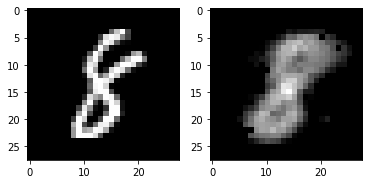

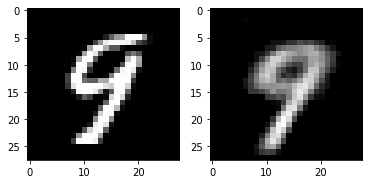

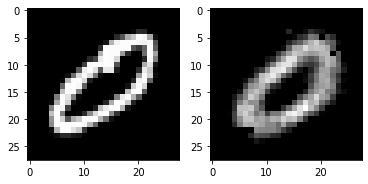

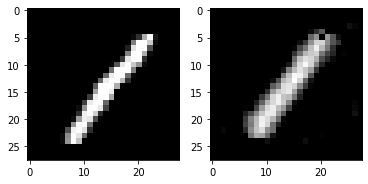

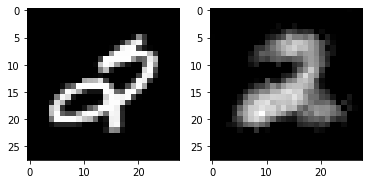

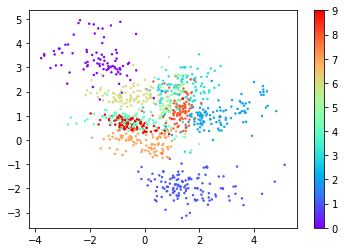

In [ ]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    optimizer.zero_grad()

    image = Variable(image).cuda()
    output = encoder(image)
    output = decoder(output)
    loss = loss_func(output, image)

    loss.backward()
    optimizer.step() 

    if j % 50 == 0:
       print("Epoch[{}/{}] MSE Loss: {:.5f}".format(i+1, num_epoch, loss.item()))

  val_loss = 0

  for j, [image, label] in enumerate(test_loader):
    image = Variable(image, requires_grad=False).cuda()
    output = encoder(image)
    output = decoder(output)
    val_loss += loss_func(output, image).item()
  print("Epoch[{}/{}] Validation MSE Loss: {:.5f}".format(i+1, num_epoch, val_loss/len(test_loader)))

  if i+1==num_epoch: # 마지막 에폭 때 
    for j, [image, label] in enumerate(test_loader):
      image = Variable(image, requires_grad=False).cuda()
      encoded_output = encoder(image)
      if j==0: # 테스트 로더에서 뽑은 첫번째 결괏값을 시각화에 사용
        encoded = encoded_output
        labels = label
      elif encoded.size(0) < 1000: # 에러 방지 코드
        encoded = torch.cat((encoded_output, encoded),0)
        labels = torch.cat((label,labels),0)

out_img = torch.squeeze(output.cpu().data)
fig = [plt.figure() for _ in range(5)]

rows = 1
cols = 2

for i in range(5):
  ax1 = fig[i].add_subplot(rows, cols, 1)
  ax1.imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')
  ax2 = fig[i].add_subplot(rows, cols, 2)
  ax2.imshow(out_img[i].numpy(), cmap='gray')

plt.show()

n = 1000
encoded = encoded.cpu().detach().numpy()
sc = plt.scatter(encoded[:,0], encoded[:,1], s=2, c=labels, cmap='rainbow')
plt.colorbar(sc)

In [ ]:
# Vanilla GAN
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Set Hyperparameters
epochs = 300
batch_size = 512
learning_rate = 0.0002
z_size = 50

mnist_train = dset.MNIST(root='./', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class fcBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(fcBlock, self).__init__()
    self.body = nn.Sequential(
        nn.Linear(in_channels, out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    out = self.body(x)
    return out

# Random noise z를 input으로 받아서 1x28x28 이미지 생성
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 50
    self.n_out = 784
    self.fc0 = fcBlock(self.n_features, 256)
    self.fc1 = fcBlock(256, 512)
    self.fc2 = fcBlock(512, 1024)
    self.fc3 = fcBlock(1024, self.n_out)
  def forward(self, x):
    x = self.fc0(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = x.view(-1, 1, 28, 28)
    return x

generator = Generator().cuda()
print(generator)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_in = 784
    self.n_out = 1
    self.fc0 = fcBlock(self.n_in, 1024)
    self.fc1 = fcBlock(1024, 512)
    self.fc2 = fcBlock(512, 256)
    self.fc3 = fcBlock(256, self.n_out)
    self.dropout = nn.Dropout(0.3)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.dropout(self.fc0(x))
    x = self.dropout(self.fc1(x))
    x = self.dropout(self.fc2(x))
    x = self.fc3(x)
    x = self.sigmoid(x) # 진짜(1)와 가짜(0)를 구별하려고 sigmoid 이용
    return x

discriminator = Discriminator().cuda()
print(discriminator)

Generator(
  (fc0): fcBlock(
    (body): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc1): fcBlock(
    (body): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc2): fcBlock(
    (body): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc3): fcBlock(
    (body): Sequential(
      (0): Linear(in_features=1024, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
)
Discriminator(
  (fc0): fcBlock(
    (body): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc1): fcBlock(
    (body): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc2): fcBlock(
    (body

In [ ]:
loss_func = nn.BCELoss()
# Genarator/Discriminator 각각에 대해 Optimizer 정의
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate)
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

generator.train()
discriminator.train()

# train
for epoch in range(epochs):
  for _, (image, label) in enumerate(train_loader):
    image = Variable(image).cuda()

    # discriminator
    dis_optim.zero_grad()
    z = Variable(init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1)).cuda()
    # Random Noise z 생성 후 generator에서 fake_image 생성
    gen_fake = generator(z)
    # 가짜 데이터 판별
    dis_fake = discriminator(gen_fake)
    # 진짜 데이터 판별  
    dis_real = discriminator(image)

    # Fake label / Real label 사용해서 더한 결과간 차이 학습
    dis_loss = torch.sum(loss_func(dis_fake, zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
    dis_loss.backward(retain_graph=True)
    dis_optim.step()

    # generator
    gen_optim.zero_grad()
    z = Variable(init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1)).cuda()
    gen_fake = generator(z)
    dis_fake = discriminator(gen_fake)

    # Discriminator에서 나온 결과를 기반으로 차이 학습 
    # (진짜 예측 결과와 가짜가 들어가서 나온 예측 결과간 차이)
    gen_loss = torch.sum(loss_func(dis_fake, ones_label))
    gen_loss.backward()
    gen_optim.step()

  print("Epoch[{}/{}] Gen Loss: {:.4f} Dis Loss: {:.4f}".format(epoch+1, epochs, gen_loss.data, dis_loss.data))

Epoch[1/300] Gen Loss: 0.3609 Dis Loss: 2.3262
Epoch[2/300] Gen Loss: 0.8330 Dis Loss: 1.6731
Epoch[3/300] Gen Loss: 0.7330 Dis Loss: 1.2829
Epoch[4/300] Gen Loss: 0.6124 Dis Loss: 2.2188
Epoch[5/300] Gen Loss: 0.9636 Dis Loss: 1.3515
Epoch[6/300] Gen Loss: 0.7586 Dis Loss: 1.0552
Epoch[7/300] Gen Loss: 1.0235 Dis Loss: 0.6245
Epoch[8/300] Gen Loss: 0.7988 Dis Loss: 0.8276
Epoch[9/300] Gen Loss: 0.8728 Dis Loss: 1.7325
Epoch[10/300] Gen Loss: 1.0918 Dis Loss: 1.2290
Epoch[11/300] Gen Loss: 0.9859 Dis Loss: 1.6662
Epoch[12/300] Gen Loss: 0.8565 Dis Loss: 0.7721
Epoch[13/300] Gen Loss: 1.7494 Dis Loss: 1.2345
Epoch[14/300] Gen Loss: 1.2993 Dis Loss: 0.5876
Epoch[15/300] Gen Loss: 1.8147 Dis Loss: 2.9103
Epoch[16/300] Gen Loss: 0.9912 Dis Loss: 0.8712
Epoch[17/300] Gen Loss: 0.8905 Dis Loss: 1.3113
Epoch[18/300] Gen Loss: 1.3872 Dis Loss: 0.9404
Epoch[19/300] Gen Loss: 1.1294 Dis Loss: 1.4235
Epoch[20/300] Gen Loss: 1.4894 Dis Loss: 0.9281
Epoch[21/300] Gen Loss: 0.8024 Dis Loss: 0.8091
E

Fake generated image


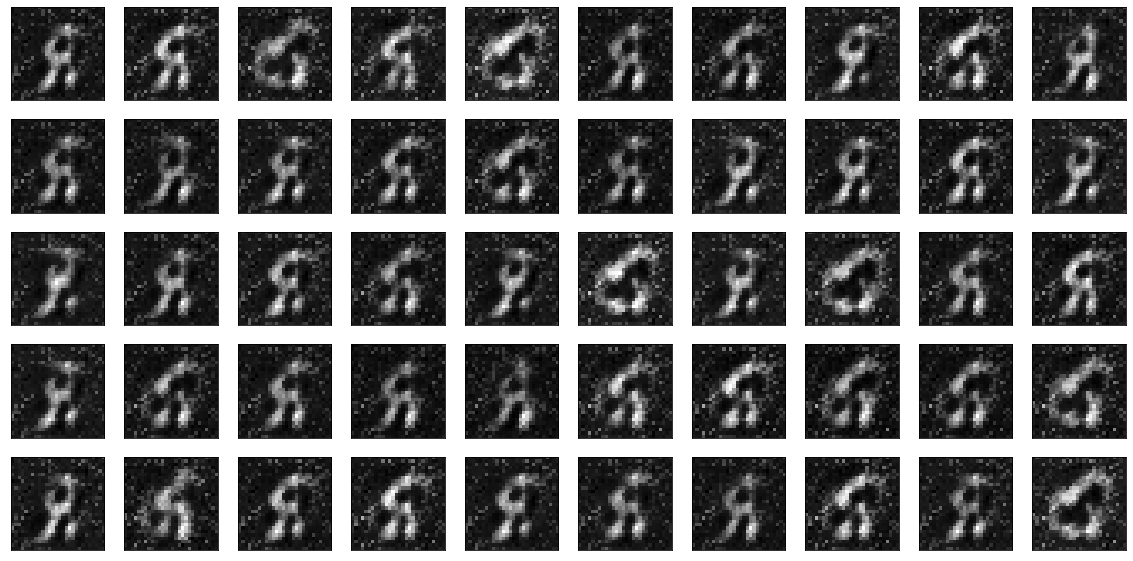

In [ ]:
# Plotting the results

print('Fake generated image')

plt.figure(figsize=(20,10))
gen_fake = gen_fake.cpu().detach().numpy()
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.imshow(gen_fake[i,:,:,:].reshape(28,28), cmap='gray')
  plt.xticks([]);plt.yticks([])
plt.show()